In [1]:
# Check for GPU
!nvidia-smi

Sun Aug  6 11:27:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  | 00000000:09:00.0  On |                  N/A |
|  0%   38C    P8              16W / 198W |    796MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import numpy as np
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.12.1


'cuda'

Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

# 1. Initialize hyperparameters

In [3]:
N_EPOCHS = 5
N_PIXELS = 784

The CNN explainer website is a great insight into all the nuts and bolts of a convolutional neural network.

# 2. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [4]:
import torchvision
import os
from torchvision import datasets, transforms

In [5]:
# Define the paths
check_path = './mnist/MNIST/raw'
download_path = '../mnist/'

# Check if MNIST dataset exists in the specified path
if not os.path.exists(check_path):
    print("MNIST dataset not found. Downloading to", download_path)
    transform = transforms.Compose([transforms.ToTensor()])

    # Download and load the MNIST train dataset
    train_data = datasets.MNIST(root=download_path,
                                train=True,
                                download=True,
                                transform=transform)

    # Download and load the MNIST test dataset
    test_data = datasets.MNIST(root=download_path,
                               train=False,
                               download=True,
                               transform=transform)
    print("MNIST dataset downloaded successfully.")
else:
    print("MNIST dataset found in", check_path)
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the MNIST train dataset from the local path
    train_data = datasets.MNIST(root=download_path,
                                train=True,
                                download=False,
                                transform=transform)

    # Load the MNIST test dataset from the local path
    test_data = datasets.MNIST(root=download_path,
                               train=False,
                               download=False,
                               transform=transform)
    print("MNIST dataset loaded from", check_path)


MNIST dataset not found. Downloading to ../mnist/
MNIST dataset downloaded successfully.


In [6]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../mnist/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../mnist/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [7]:
len(train_data), len(test_data)

(60000, 10000)

In [8]:
'''# Data is in tuple form (image, label)
img = train_data[2][0]
label = train_data[2][1]
print(f"Image:\n {img}")
print(f"Label:\n {label}")

# Check out the shapes of our data
print(f"Image shape: {img.shape} -> [color_channels, height, width] (CHW)")
print(f"Label: {label} -> no shape, due to being integer")'''

'# Data is in tuple form (image, label)\nimg = train_data[2][0]\nlabel = train_data[2][1]\nprint(f"Image:\n {img}")\nprint(f"Label:\n {label}")\n\n# Check out the shapes of our data\nprint(f"Image shape: {img.shape} -> [color_channels, height, width] (CHW)")\nprint(f"Label: {label} -> no shape, due to being integer")'

Note: There are two main agreed upon ways for representing images in machine learning:
1. Color channels first: [color_channels, height, width] (CHW) -> PyTorch default (as of April 2022)
2. Color channels last: [height, width, color_channels] (HWC) -> Matplotlib/TensorFlow default (as of April 2022)

In [9]:
# Get the class names from the dataset
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# 3. Visualize at least 5 different samples of the MNIST training dataset.

In [10]:
import matplotlib.pyplot as plt

'''for i in range(5):
  img = train_data[i][0]
  print(img.shape)
  img_squeeze = img.squeeze()
  print(img_squeeze.shape)
  label = train_data[i][1]
  plt.figure(figsize=(3, 3))
  plt.imshow(img_squeeze, cmap="gray")
  plt.title(label)
  plt.axis(False)'''

'for i in range(5):\n  img = train_data[i][0]\n  print(img.shape)\n  img_squeeze = img.squeeze()\n  print(img_squeeze.shape)\n  label = train_data[i][1]\n  plt.figure(figsize=(3, 3))\n  plt.imshow(img_squeeze, cmap="gray")\n  plt.title(label)\n  plt.axis(False)'

# 4. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [11]:
# Create train dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=16,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=16,
                             shuffle=False)

In [12]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2088e26af40>,
 <torch.utils.data.dataloader.DataLoader at 0x2088e26ad60>)

In [13]:
for sample in next(iter(train_dataloader)):
  print(sample.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [14]:
len(train_dataloader), len(test_dataloader)

(3750, 625)

# 5. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [15]:
from torch import nn

class MNISTModel(torch.nn.Module):
  """Model capable of predicting on MNIST dataset.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )

  def forward(self, x, return_flattened=False):
    """
    :param return_flattened: 
    :param x:
    :return:
    """
    x = self.conv_block_1(x)
    # print(f"Output shape of conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv block 2: {x.shape}")
    # Before applying classifier, just flatten and print the shape
    x_flattened = nn.Flatten()(x) # Flatten the tensor
    # self.get_flatten = nn.Flatten()(x) # flatten and save to a class attribute
    # print(f"Shape after flattening: {x_flattened.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    if return_flattened:
        return x, x_flattened
    else:
        return x

In [16]:
device

'cuda'

In [17]:
model = MNISTModel(input_shape=1,
                    hidden_units=10,
                    output_shape=10).to(device)
model

MNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [18]:
# Create a random input tensor with the shape that matches a single MNIST image (1, 28, 28)
# Note: The first 1 is the batch size, indicating we're feeding 1 image.
my_input_tensor = torch.randn(1, 1, 28, 28).to(device)
print(my_input_tensor.shape)

# Pass the input tensor through the model to print the output shapes of each block
my_output = model(my_input_tensor)
my_output

torch.Size([1, 1, 28, 28])


tensor([[ 0.0440, -0.0212, -0.0121,  0.0136,  0.0365,  0.0015, -0.0039, -0.1181,
         -0.0200, -0.0096]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
# # Check out the model state dict to find out what patterns our model wants to learn
# model.state_dict()

In [20]:
weights = model.classifier[1].weight.data
bias = model.classifier[1].bias.data

print(weights)
print(bias)

tensor([[ 0.0181,  0.0043,  0.0273,  ..., -0.0160, -0.0147,  0.0162],
        [-0.0046,  0.0271,  0.0339,  ...,  0.0231,  0.0327,  0.0369],
        [-0.0248,  0.0407,  0.0403,  ...,  0.0170,  0.0145, -0.0158],
        ...,
        [-0.0449,  0.0221, -0.0031,  ..., -0.0174, -0.0282, -0.0246],
        [ 0.0090,  0.0120,  0.0180,  ...,  0.0144,  0.0176, -0.0428],
        [-0.0354,  0.0268, -0.0171,  ...,  0.0045,  0.0262, -0.0164]],
       device='cuda:0')
tensor([ 0.0439, -0.0227, -0.0197, -0.0308,  0.0200,  0.0326, -0.0399, -0.0341,
        -0.0284, -0.0281], device='cuda:0')


In [21]:
# Try a dummy forward pass to see what shapes our data is
dummy_x = torch.rand(size=(1, 28, 28)).unsqueeze(dim=0).to(device)

print(dummy_x.shape)
model(dummy_x)
# dummy_x

torch.Size([1, 1, 28, 28])


tensor([[ 0.0365, -0.0015,  0.0001,  0.0015,  0.0089,  0.0023, -0.0190, -0.0846,
         -0.0033, -0.0151]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
dummy_x_2 = torch.rand(size=([1, 10, 7, 7]))
dummy_x_2.shape

torch.Size([1, 10, 7, 7])

In [23]:
flatten_layer = nn.Flatten()
flatten_layer(dummy_x_2).shape

torch.Size([1, 490])

# 6. Train the model.

In [24]:
model_weights_path = "../model_weights/"

device = "cuda" if torch.cuda.is_available() else "cpu"

model_gpu = MNISTModel(input_shape=1,
                       hidden_units=10,
                       output_shape=10).to(device)

In [25]:
%%time
from tqdm.auto import tqdm
import os

# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.1)

# Training loop
for epoch in tqdm(range(1, N_EPOCHS + 1)):
  train_loss = 0
  model_gpu.train()
  for batch, (X, y) in enumerate(train_dataloader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model_gpu(X)
    # print(type(y_pred), y_pred)

    # Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()

  # Adjust train loss to number of batches
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss_total = 0
  
  # Put model in eval mode and turn on inference mode
  model_gpu.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Make sure test data on target device
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model_gpu(X_test)
      test_loss = loss_fn(test_pred, y_test)

      test_loss_total += test_loss.item()

    # Adjust test loss total for number of batches
    test_loss_total /= len(test_dataloader)

  # Print out what's happening
  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")

  # Save model weights after each epoch
  save_path = os.path.join(model_weights_path, f"model_epoch_{epoch}.pth")
  os.makedirs(os.path.dirname(save_path), exist_ok=True)
  torch.save(model_gpu.state_dict(), save_path)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.201 | Test loss: 0.081
Epoch: 2 | Loss: 0.065 | Test loss: 0.046
Epoch: 3 | Loss: 0.053 | Test loss: 0.045
Epoch: 4 | Loss: 0.044 | Test loss: 0.042
Epoch: 5 | Loss: 0.040 | Test loss: 0.036
Epoch: 6 | Loss: 0.037 | Test loss: 0.039
Epoch: 7 | Loss: 0.035 | Test loss: 0.052
Epoch: 8 | Loss: 0.033 | Test loss: 0.042
Epoch: 9 | Loss: 0.030 | Test loss: 0.048
Epoch: 10 | Loss: 0.030 | Test loss: 0.050
CPU times: total: 41.2 s
Wall time: 3min 54s


# 7. Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

In [26]:
# Make predictions with the trained model
# plt.imshow(test_data[0][0].squeeze(), cmap="gray")

In [27]:
# Logits -> Prediction probabilities -> Prediction labels
old_model_pred_logits = model_gpu(test_data[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
old_model_pred_probs = torch.softmax(old_model_pred_logits, dim=1)
old_model_pred_label = torch.argmax(old_model_pred_probs, dim=1)
old_model_pred_label

tensor([7], device='cuda:0')

In [28]:
num_to_plot = 5

for i in range(num_to_plot):
  # Get image and labels from the test data
  img = test_data[i][0]
  label = test_data[i][1]

  # Make prediction on image
  old_model_pred_logits = model_gpu(img.unsqueeze(dim=0).to(device))
  old_model_pred_probs = torch.softmax(old_model_pred_logits, dim=1)
  old_model_pred_label = torch.argmax(old_model_pred_probs, dim=1)
# 
#   # Plot the image and prediction
#   plt.figure()
#   plt.imshow(img.squeeze(), cmap="gray")
#   plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}")
#   plt.axis(False)

# 8. Generate sample dataset and its weights

In [29]:
from my_functions import generate_sample_dataset

n_samples_train = 10000
n_samples_test = 1000

my_sample_dataset_train, my_indices_train = generate_sample_dataset(train_data, n_samples_train)
my_sample_dataset_test, my_indices_test = generate_sample_dataset(test_data, n_samples_test)

In [30]:
print(f"The length of indices is {len(my_indices_train)}.")
print(f"The length of indices is {len(my_indices_test)}.")

The length of indices is 10000.
The length of indices is 1000.


In [31]:
def generate_prediction_weights(input_dataset, input_weights_path):
    """
    This function extracts the weights from the model in the prediction stage
    :param input_dataset:
    :param input_weights_path:
    :return:
    """
    # total_images = len(input_dataset)

    my_true_labels = []
    my_pred_flattened = []
    my_pred_logits = []
    my_pred_labels = []

    sample_model = MNISTModel(input_shape=1, hidden_units=10, output_shape=10).to(device)

    sample_model.load_state_dict(torch.load(os.path.join(input_weights_path,
                                                         f"model_epoch_{N_EPOCHS}.pth")))  # Load your trained weights
    sample_model.eval()  # Set the model to evaluation mode

    with torch.inference_mode():
        for sample_batch, (x_sample, y_sample) in tqdm(enumerate(input_dataset)):
            x_sample = x_sample.to(device)
            preds, flattened = sample_model(x_sample.unsqueeze(dim=0).to(device), return_flattened=True)

            # Save the true labels for each image
            my_true_labels.append(y_sample)

            # Save the activations after the nn.Flatten() layer for each image
            my_pred_flattened.append(flattened)

            # Save the prediction logits
            my_pred_logits.append(preds)

            # Save the prediction labels
            model_pred_labels = torch.argmax(torch.softmax(preds, dim=1), dim=1)
            my_pred_labels.append(model_pred_labels)

            # At this point, `flattened_outputs` is a list of tensors,
            # where each tensor corresponds to the flattened outputs for a batch of data.

        my_pred_flattened = torch.cat(my_pred_flattened, dim=0).cpu()  # Concatenate all activations
        my_pred_logits = torch.cat(my_pred_logits).cpu()
        my_pred_labels = torch.cat(my_pred_labels).cpu()

    return my_pred_flattened, my_pred_logits, my_pred_labels, my_true_labels


In [32]:
my_prediction_weights_train = generate_prediction_weights(my_sample_dataset_train, model_weights_path)

my_prediction_weights_test = generate_prediction_weights(my_sample_dataset_test, model_weights_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [33]:
print(my_prediction_weights_train[0].shape)
print(my_prediction_weights_test[0].shape)

torch.Size([10000, 490])
torch.Size([1000, 490])


In [34]:
# from google.colab import drive

# drive.mount("/content/drive")

# drive_path = "/content/drive/My Drive/Colab Notebooks/mnist"
# drive_path = D:\GitHub\transition-matrix-ml\mnist"
# drive_path = r"E:\GitHub\transition-matrix-ml\MNIST"
# drive_path = "C:/Courses/transition-matrix-ml/mnist"

drive_path = '../mnist/'

In [35]:
import pandas as pd
import csv

def tensor_to_dataframe(tensor):
    """Convert a PyTorch tensor to a pandas DataFrame."""
    return pd.DataFrame(tensor.cpu().detach().numpy())

In [36]:
# Train data
# Save the images and labels to a CSV file
with open(f"{drive_path}/mnist_matrix_B_train.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)

    # Header
    header = ["unique_id", "label"] + ["pixel" + str(i) for i in range(N_PIXELS)]
    csv_writer.writerow(header)

    # Rows
    for sample_idx, (sample_image, sample_label) in zip(my_indices_train, my_sample_dataset_train):
        sample_image = sample_image[0].numpy().flatten()  # Extract the tensor from the tuple
        row = [sample_idx, sample_label] + sample_image.tolist()
        csv_writer.writerow(row)


In [37]:
# Convert the tensor to a DataFrame
df_flattened_train = tensor_to_dataframe(my_prediction_weights_train[0])
df_logits_train = tensor_to_dataframe(my_prediction_weights_train[1])
df_preds_train = tensor_to_dataframe(my_prediction_weights_train[2])
df_labels_train = pd.DataFrame(my_prediction_weights_train[3])

# Convert indices to a DataFrame
df_indices_train = pd.DataFrame(my_indices_train, columns=["unique_id"])

# Concatenate indices with other DataFrames
df_flattened_train = pd.concat([df_indices_train, df_flattened_train], axis=1)
df_logits_train = pd.concat([df_indices_train, df_logits_train], axis=1)
df_preds_train = pd.concat([df_indices_train, df_preds_train], axis=1)
df_labels_train = pd.concat([df_indices_train, df_labels_train], axis=1)

# Save the DataFrame to a CSV file
with open(f"{drive_path}/mnist_matrix_A_train.csv", "w", newline="") as file_flattened:
    df_flattened_train.to_csv(file_flattened)
with open(f"{drive_path}/mnist_logits_train.csv", "w", newline="") as file_logits:
    df_logits_train.to_csv(file_logits)
with open(f"{drive_path}/mnist_pred_labels_train.csv", "w", newline="") as file_preds:
    df_preds_train.to_csv(file_preds)
with open(f"{drive_path}/mnist_true_labels_train.csv", "w", newline="") as file_labels:
    df_labels_train.to_csv(file_labels)


In [38]:
# Test data
# Save the images and labels to a CSV file
with open(f"{drive_path}/mnist_matrix_B_test.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)

    # Header
    header = ["unique_id", "label"] + ["pixel" + str(i) for i in range(N_PIXELS)]
    csv_writer.writerow(header)

    # Rows
    for sample_idx, (sample_image, sample_label) in zip(my_indices_test, my_sample_dataset_test):
        sample_image = sample_image[0].numpy().flatten()  # Extract the tensor from the tuple
        row = [sample_idx, sample_label] + sample_image.tolist()
        csv_writer.writerow(row)


In [39]:
# Convert the tensor to a DataFrame
df_flattened_test = tensor_to_dataframe(my_prediction_weights_test[0])
df_logits_test = tensor_to_dataframe(my_prediction_weights_test[1])
df_preds_test = tensor_to_dataframe(my_prediction_weights_test[2])
df_labels_test = pd.DataFrame(my_prediction_weights_test[3])

# Convert indices to a DataFrame
df_indices_test = pd.DataFrame(my_indices_test, columns=["unique_id"])

# Concatenate indices with other DataFrames
df_flattened_test = pd.concat([df_indices_test, df_flattened_test], axis=1)
df_logits_test = pd.concat([df_indices_test, df_logits_test], axis=1)
df_preds_test = pd.concat([df_indices_test, df_preds_test], axis=1)
df_labels_test = pd.concat([df_indices_test, df_labels_test], axis=1)

# Save the DataFrame to a CSV file
with open(f"{drive_path}/mnist_matrix_A_test.csv", "w", newline="") as file_flattened:
    df_flattened_test.to_csv(file_flattened)
with open(f"{drive_path}/mnist_logits_test.csv", "w", newline="") as file_logits:
    df_logits_test.to_csv(file_logits)
with open(f"{drive_path}/mnist_pred_labels_test.csv", "w", newline="") as file_preds:
    df_preds_test.to_csv(file_preds)
with open(f"{drive_path}/mnist_true_labels_test.csv", "w", newline="") as file_labels:
    df_labels_test.to_csv(file_labels)


# 9. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [40]:
'''# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mldxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")'''

'# See if torchmetrics exists, if not, install it\ntry:\n    import torchmetrics, mldxtend\n    print(f"mlxtend version: {mlxtend.__version__}")\n    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"\nexcept:\n    !pip install -q torchmetrics -U mlxtend # <- Note: If you\'re using Google Colab, this may require restarting the runtime\n    import torchmetrics, mlxtend\n    print(f"mlxtend version: {mlxtend.__version__}")'

In [41]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be versioned 0.19.0 or higher

0.22.0


In [42]:
# Make predictions across all test data
from tqdm.auto import tqdm
model_gpu.eval()
y_preds = []
with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_dataloader)):
        # Make sure data on right device
        X, y = X.to(device), y.to(device)
        # Forward pass
        y_pred_logits = model_gpu(X)
        # Logits -> Pred probs -> Pred label
        y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        # Append the labels to the preds list
        y_preds.append(y_pred_labels)
    y_preds = torch.cat(y_preds).cpu()
len(y_preds)
print(y_preds)

0it [00:00, ?it/s]

tensor([7, 2, 1,  ..., 4, 5, 6])


In [43]:
test_data.targets[:10], y_preds[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

C:\Users\radiu\anaconda3\envs\rnd-gpu\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


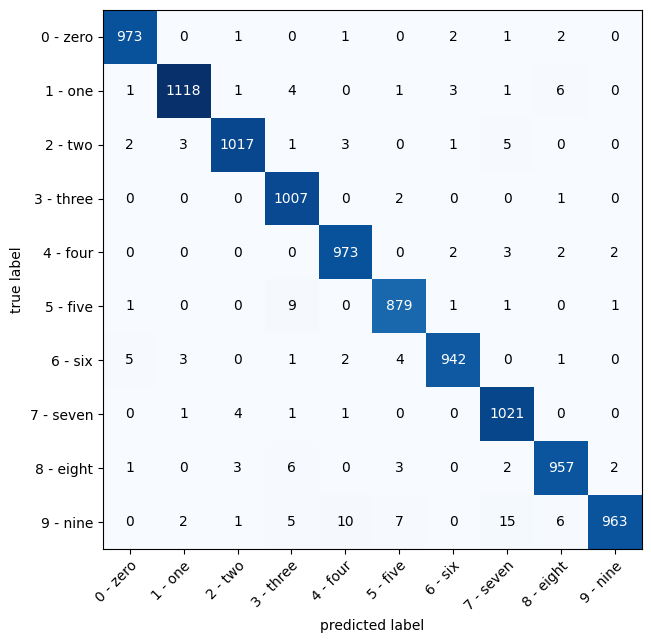

In [44]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# 10. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

random_tensor = torch.rand([1, 3, 64, 64])
random_tensor.shape

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=64,
                       kernel_size=3,
                       stride=2,
                       padding=1)

print(f"Random tensor original shape: {random_tensor.shape}")
random_tensor_through_conv_layer = conv_layer(random_tensor)
print(f"Random tensor through conv layer shape: {random_tensor_through_conv_layer.shape}")

# 11. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

# Download FashionMNIST train & test
from torchvision import datasets
from torchvision import transforms

fashion_mnist_train = datasets.FashionMNIST(root=".",
                                            download=True,
                                            train=True,
                                            transform=transforms.ToTensor())

fashion_mnist_test = datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

len(fashion_mnist_train), len(fashion_mnist_test)

## Get the class names of the Fashion MNIST dataset
fashion_mnist_class_names = fashion_mnist_train.classes
fashion_mnist_class_names

## Turn FashionMNIST datasets into dataloaders
from torch.utils.data import DataLoader

fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train,
                                            batch_size=16,
                                            shuffle=True)

fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test,
                                           batch_size=16,
                                           shuffle=False)

len(fashion_mnist_train_dataloader), len(fashion_mnist_test_dataloader)

## model_2 is the same architecture as MNISTModel
model_2 = MNISTModel(input_shape=1,
                      hidden_units=10,
                      output_shape=10).to(device)
model_2

## Setup loss and optimizer
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

## Setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=len(fashion_mnist_class_names)).to(device)

## Setup training/testing loop
N_EPOCHS = 2
for epoch in tqdm(range(N_EPOCHS)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0

  ### Training
  model_2.train()
  for batch, (X_train, y_train) in enumerate(fashion_mnist_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass and loss
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred, y_train)

    # Backprop and gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  ## Adjust the loss/acc (find the loss/acc per epoch)
  train_loss /= len(fashion_mnist_train_dataloader)
  train_acc /= len(fashion_mnist_train_dataloader)

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_mnist_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass and loss
      y_pred_test = model_2(X_test)
      test_loss = loss_fn(y_pred_test, y_test)
      test_loss_total += test_loss

      test_acc += acc_fn(y_pred_test, y_test)
  
    # Adjust the loss/acc (find the loss/acc per epoch)
    test_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)
    
  ## Print out what's happening
  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc:.2f}")

## Make predictions with trained model_2
test_preds = []
model_2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader):
    y_logits = model_2(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)    

## Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_mnist_test.targets)[0]
len(wrong_pred_indexes)

## Select random 9 wrong predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  ### Get true and pred labels
  true_label = fashion_mnist_class_names[fashion_mnist_test[idx][1]]
  pred_label = fashion_mnist_class_names[test_preds[idx]]

  ### Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False)

From the look of some of these predictions, the model is getting about as confused as I would...

For example it predicts "Sneaker" instead of "Sandal" when it could have easily been a "Sneaker".

The same goes for the confusion between the classes of "T-shirt/top" and "Shirt", many of the examples here look similar.